In [45]:
import nest;
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from utils.inputs import generate_piecewise_constant_signal
from scipy.stats import pearsonr

In [46]:
pip install scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel

# Functions for the code

# Introduction to Spiking Neural Networks

In order to start doing the standard Brunel balanced random network. This network is composed of a sparsely connected excitatory and inhibitory integrate-and-fire neurons. It can switch between asynchronous and syncrhonous states.


[1]: Brunel N (2000). Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8, 183-208.

In [48]:
def bin_spikes(spikes, bin_width, min_time):
    senders = spikes.events['senders']
    times = spikes.events['times']
    
    # Create a dictionary to hold spike times for each neuron
    spike_times_by_neuron = {}
    
    # Iterate over senders and times
    for sender, time in zip(senders, times):
        if sender not in spike_times_by_neuron:
            spike_times_by_neuron[sender] = []  # Initialize list if neuron not yet present
        spike_times_by_neuron[sender].append(time)
    
    binned_spike_counts = {}
    # Find the global min and max times for the bins
    max_time = max(times)
    
    # Define bins: from min_time to max_time in steps of 5 ms
    bins = np.arange(min_time, max_time + bin_width, bin_width)
    
    # Iterate over each neuron and bin their spike times
    for neuron, spike_times in spike_times_by_neuron.items():
        # Use np.histogram to bin the spike times for the current neuron
        counts, _ = np.histogram(spike_times, bins=bins)
        
        # Store the binned spike counts for each neuron
        binned_spike_counts[neuron] = counts

    # Get the number of neurons and the number of bins
    neuron_ids = list(binned_spike_counts.keys())
    num_neurons = len(neuron_ids)
    num_bins = len(next(iter(binned_spike_counts.values())))  # Get the number of bins from the first neuron's data
    
    # Create a 2D array to hold the binned counts
    heatmap_data = np.zeros((num_neurons, num_bins))
    
    # Fill the heatmap data array
    for i, neuron in enumerate(neuron_ids):
        heatmap_data[i, :] = binned_spike_counts[neuron]

    return binned_spike_counts, heatmap_data

In [49]:
def average_correlation(matrix, num_pairs, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set the random seed for reproducibility

    # Randomly select unique pairs of rows
    num_rows = matrix.shape[0]
    if num_pairs > (num_rows * (num_rows - 1)) // 2:
        raise ValueError("num_pairs exceeds the number of unique pairs of rows.")
    # Randomly select 500 unique pairs of rows
    num_rows = matrix.shape[0]
    selected_pairs = set()
    while len(selected_pairs) < num_pairs:
        row1 = np.random.randint(0, num_rows)
        row2 = np.random.randint(0, num_rows)
        # Ensure that we don't select the same row for both pairs (no autocorrelation)
        if row1 != row2:
            selected_pairs.add((row1, row2))
    
    # Compute the correlation for each selected pair
    correlations = []
    for row1, row2 in selected_pairs:
        corr, _ = pearsonr(matrix[row1], matrix[row2])
        correlations.append(corr)
    
    # Average the correlations
    average_correlation = np.mean(correlations)
    return average_correlation

In [50]:
def calculate_cv(spike_times):
    """
    Calculate the coefficient of variation (CV) for a given neuron's spike times.
    
    Parameters:
    spike_times (list of float): List of spike times for a neuron.
    
    Returns:
    float: Coefficient of variation.
    """
    if len(spike_times) < 2:
        return 0.0  # CV is not defined for less than 2 spikes
    
    isi = np.diff(spike_times)  # Inter-spike intervals
    mean_isi = np.mean(isi)
    std_isi = np.std(isi)
    
    cv = std_isi / mean_isi
    return cv

def collect_cvs(spikes):
    """
    Collect the CVs for all neurons.
    
    Parameters:
    spikes (list of list of float): List of spike times for each neuron.
    
    Returns:
    list of float: List of CVs for each neuron.
    """
    cvs = [calculate_cv(spike_times) for spike_times in spikes]
    return cvs

def plot_cv_distribution(cvs, title):
    """
    Plot the distribution of CVs.
    
    Parameters:
    cvs (list of float): List of CVs for each neuron.
    title (str): Title for the plot.
    """
    plt.hist(cvs, bins=30, edgecolor='black')
    plt.xlabel('Coefficient of Variation (CV)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


# Group spike times by neuron ID
def group_spike_times_by_neuron(spikes):
    senders = spikes['senders']
    times = spikes['times']
    spike_dict = {}
    for sender, time in zip(senders, times):
        if sender not in spike_dict:
            spike_dict[sender] = []
        spike_dict[sender].append(time)
    return spike_dict

In [51]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [52]:
def filter_spikes_parallel(spike_times, neuron_ids, n_neurons, t_start, t_stop, dt, tau, n_processes):
    """
    Returns an NxT matrix where each row represents the filtered spiking activity of
    one neuron and the columns represent time...

    Inputs:
        - spike_times - list of spike times
        - neuron_ids - list of spike ids
        - dt - time step
        - tau - kernel time constant
        - n_processes - number of processes to use for parallel computation
        - show_progess - if True a progress bar is printed
    """
    spk_times_list = order_array_by_ids(spike_times, n_neurons, neuron_ids)
    arg_list = [
        {
            "spike_times": spkt,
            "t_start": t_start,
            "t_stop": t_stop,
            "dt": dt,
            "tau": tau,
        }
        for spkt in spk_times_list
    ]
    with Pool(n_processes) as p:
        state_mat = list(
            tqdm(p.imap(spikes_to_states_from_dict, arg_list), desc="Filtering SpikeTrains", total=n_neurons)
        )

    return np.array(state_mat)


## 1. Stationary Spiking Neural Network - Homogenous Poisson Process

In [84]:
#Simulation Parameters
dt = 0.1  # simulation resolution
sim_time = 25000. # simulation time [ms] (for each epoch)
num_threads = 8

In [85]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 1.1 Create Neural Models and Network

Leaky integrate-and-fire model where the potential jumps on each spike arrival. The threshold crossing is followed by an absolute refractory period during which the membrane potential is clamped to the resting potential. Spikes arriving while the neuron is refractory, are discarded by default.

References:

[1] Rotter S, Diesmann M (1999). Exact simulation of time-invariant linear systems with applications to neuronal modeling. Biologial Cybernetics 81:381-402. DOI: https://doi.org/10.1007/s004220050570

[2] Diesmann M, Gewaltig M-O, Rotter S, & Aertsen A (2001). State space analysis of synchronous spiking in cortical neural networks. Neurocomputing 38-40:565-571. DOI: https://doi.org/10.1016/S0925-2312(01)00409-X

In [86]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [87]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [88]:
#Connect Network

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

#### 1.2 Generate Input and Connect to excitatory connection weight

In [89]:
# external input parameters (background noise)
V_th = 20.           # spike threshold (mV)
tau_m = 20.          # membrane time constant (ms)

nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 1.0 * nu_th             # set external rate above threshold
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

In [91]:
spikes_E_noise = nest.Create('spike_recorder')
spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
spikes_I_noise.stop = sim_time

vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt})

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(vm, neurons_e)

#### 1.3 Simulate and Analyse

In [92]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 12.411439999999999 Hz (E: 12.29328 Hz, I: 12.5296 Hz)


#### 1.4 Raster Plot

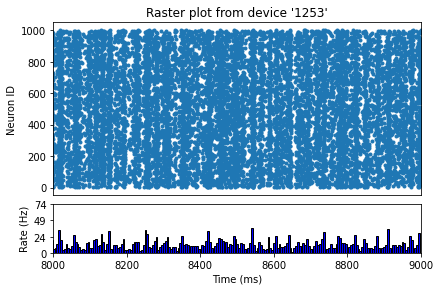

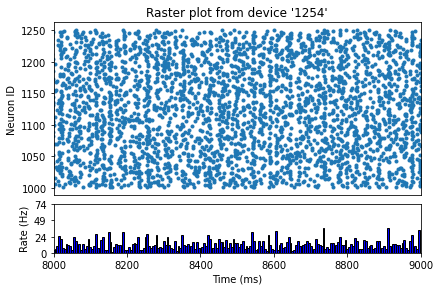

In [93]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_noise, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

#### 1.5 Spike Bin and Average Correlation

In [94]:
binned_spike_counts,heatmap_data = bin_spikes(spikes_E_noise, bin_width = 5, min_time=5000)

In [95]:
num_pairs = 1000
corr = average_correlation(heatmap_data, num_pairs)
print(f'Average Correlation for {num_pairs} pairs: {corr}')

Average Correlation for 1000 pairs: 0.02514024626916994


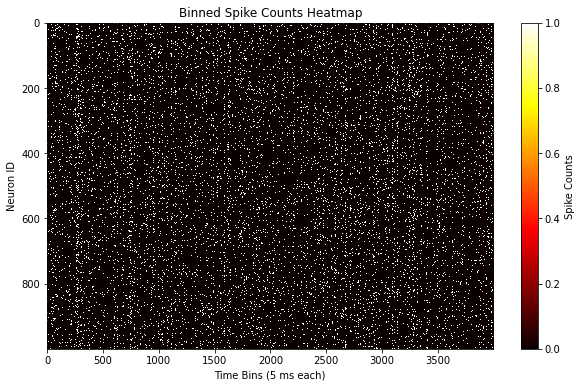

In [96]:
# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Counts')
#plt.xticks(ticks=np.arange(num_bins), labels=[f'Bin {i+1}' for i in range(num_bins)])
#plt.yticks(ticks=np.arange(num_neurons), labels=neuron_ids)
plt.title('Binned Spike Counts Heatmap')
plt.xlabel('Time Bins (5 ms each)')
plt.ylabel('Neuron ID')
plt.show()

#### 1.6 Coefficient of Variation

NodeCollection(metadata=None, model=spike_recorder, size=1, first=1253)
307332
NodeCollection(metadata=None, model=spike_recorder, size=1, first=1251)


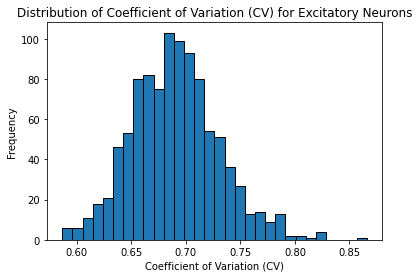

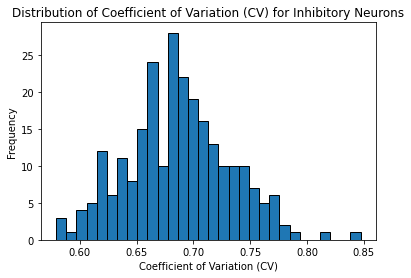

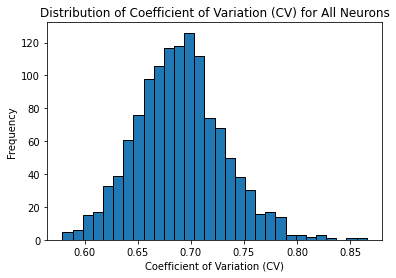

In [97]:
print(spikes_E_noise)
print(events_ex)
print(spikes_e)
# Extract spike times from NEST simulation
spikes_E_noise= nest.GetStatus(spikes_E_noise, 'events')[0]
spikes_I_noise= nest.GetStatus(spikes_I_noise, 'events')[0]
spike_times_E = group_spike_times_by_neuron(spikes_E_noise)
spike_times_I = group_spike_times_by_neuron(spikes_I_noise)

# Convert the spike times dictionary to a list of lists
neurons_spike_times_E = list(spike_times_E.values())
neurons_spike_times_I = list(spike_times_I.values())

# Collect CVs for excitatory and inhibitory neurons separately
cvs_E = collect_cvs(neurons_spike_times_E)
cvs_I = collect_cvs(neurons_spike_times_I)


# Plot the distribution of CVs for excitatory neurons
plot_cv_distribution(cvs_E, 'Distribution of Coefficient of Variation (CV) for Excitatory Neurons')

# Plot the distribution of CVs for inhibitory neurons
plot_cv_distribution(cvs_I, 'Distribution of Coefficient of Variation (CV) for Inhibitory Neurons')

# Combine CVs and plot the distribution for both
cvs_combined = cvs_E + cvs_I
plot_cv_distribution(cvs_combined, 'Distribution of Coefficient of Variation (CV) for All Neurons')

#### 1.7 Memory Capacity

In [ ]:
activity = vm.events
indices = np.sort(np.unique(activity['senders']))
time=int(sim_time/dt)
print(time)
states = np.zeros((NE, time))
for idx, i in enumerate(indices):
    states[idx, :] = activity['V_m'][np.where(activity['senders']==i)[0]]

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning:invalid value encountered in divide


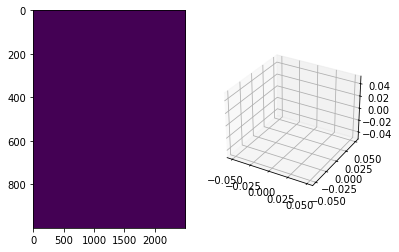

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

# 2. Stationary Spiking Neural Network - Inhomogenous Poisson Process (Stimulus)

We need to introduce a basal homogenous poisson process stimulus if not the stimulus driven input if reaches zero will imply a zero input into the netwrok, therefore, no firing and continuation

In [ ]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 2.1 Create Neural Models and Network

In [ ]:
#### PARAMETERS ###
sim_time = 25000. # simulation time [ms] (for each epoch)
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [ ]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [ ]:
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
#nest.Connect(neurons_e, spikes_e)

#### 2.2 Generate Input and Connect to excitatory connection weight

In [ ]:
# external input (stimulus)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)
step_duration = 20.    # [ms]
scale = p_rate/2    # scale input amplitude (max. rate)
stim_time=5000
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, 
                                                                           num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += stim_time  # stimulus starts after the noise phase

inp_amplitudes *= 2

In [ ]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(inp_times, inp_amplitudes)
#ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [ ]:
#create poisson generator (basal noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': stim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})


# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

In [ ]:
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_stim)

#### 2.3 Simulate and Analyse

In [ ]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

#### 2.4 Raster Plot

In [ ]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_stim, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

#### 2.5 Spike Bin and Average Correlation

In [ ]:
binned_spike_counts,heatmap_data = bin_spikes(spikes_E_stim, bin_width = 5, min_time=5000)

In [ ]:
num_pairs = 1000
corr = average_correlation(heatmap_data, num_pairs)
print(f'Average Correlation for {num_pairs} pairs: {corr}')

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Counts')
#plt.xticks(ticks=np.arange(num_bins), labels=[f'Bin {i+1}' for i in range(num_bins)])
#plt.yticks(ticks=np.arange(num_neurons), labels=neuron_ids)
plt.title('Binned Spike Counts Heatmap')
plt.xlabel('Time Bins (5 ms each)')
plt.ylabel('Neuron ID')
plt.show()

# 3. Spiking Neural Network with Synapse Model - Synaptic Time Dependent Plasticity (STDP)

In [ ]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 3.1 Create Neural Models And Network

In [ ]:
#### PARAMETERS ###
sim_time = 25000. # simulation time [ms] (for each epoch) Put it to 10000
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [ ]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [ ]:
#Connect Network

#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

syn_dict = {"synapse_model": "excitatory_plastic"}
            
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
nest.Connect(neurons_e, spikes_e)

#### 3.2 Generate Input and Connect to excitatory connection weight

In [ ]:
# external input parameters (background noise)
V_th = 20.           # spike threshold (mV)
tau_m = 20.          # membrane time constant (ms)

nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 1. * nu_th             # set external rate above threshold (changed from 2 to 1)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

In [ ]:
spikes_E_noise = nest.Create('spike_recorder')
#spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
#spikes_I_noise.stop = sim_time

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_i, spikes_I_noise)

#### 3.3 Simulate and Analyse

In [ ]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

#### 3.4 Raster Plot

In [ ]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_noise, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

#### 3.5 Spike Bin and Average Correlation

In [ ]:
binned_spike_counts,heatmap_data = bin_spikes(spikes_E_noise, bin_width = 5, min_time=5000)

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Counts')
#plt.xticks(ticks=np.arange(num_bins), labels=[f'Bin {i+1}' for i in range(num_bins)])
#plt.yticks(ticks=np.arange(num_neurons), labels=neuron_ids)
plt.title('Binned Spike Counts Heatmap')
plt.xlabel('Time Bins (5 ms each)')
plt.ylabel('Neuron ID')
plt.show()

In [ ]:
num_pairs = 1000
corr = average_correlation(heatmap_data, num_pairs)
print(f'Average Correlation for {num_pairs} pairs: {corr}')

**STDP tends to promote synchronization** in spiking neural networks by strengthening synapses between neurons that fire together and weakening those between asynchronously firing neurons.

[1]: Thomas Nowotny. Enhancement of Synchronization in a Hybrid Neural Circuit by Spike-Timing Dependent Plasticity. Journal of Neuroscience, 2003.

# 4. Spiking Neural Network with Synapse Model STDP - Stimulus + Noise Input

Look at the weight after 10 s, in both, and then also start driven stimulus after 5 s, before background noise

In [ ]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 4.1 Create Neural Models and Network

In [ ]:
#### PARAMETERS ###
sim_time = 25000. # simulation time [ms] (for each epoch)
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [ ]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [ ]:
#Connect Network

#Heterogenity
alpha_min = 0.1
alpha_max = 1

#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

syn_dict = {"synapse_model": "excitatory_plastic"}
            
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
nest.Connect(neurons_e, spikes_e)

#### 4.2 Stimulus Input and connection to the system

In [ ]:
# external input (stimulus)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)
step_duration = 20.    # [ms]
scale = p_rate/2    # scale input amplitude (max. rate)
stim_time = 5000
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, 
                                                                           num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)

inp_times += stim_time  # stimulus starts after the noise phase

inp_amplitudes*=2

In [ ]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 10000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [ ]:
# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': stim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

In [ ]:
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_stim)

#### 4.3 Simulate and Analyse

In [ ]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

#### 4.4 Raster Plot

In [ ]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_stim, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

#### 4.5 Spike Bin and Average Correlation

In [ ]:
binned_spike_counts,heatmap_data = bin_spikes(spikes_E_stim, bin_width = 5, min_time=5000)

In [ ]:
num_pairs = 1000
corr = average_correlation(heatmap_data, num_pairs)
print(f'Average Correlation for {num_pairs} pairs: {corr}')

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Counts')
#plt.xticks(ticks=np.arange(num_bins), labels=[f'Bin {i+1}' for i in range(num_bins)])
#plt.yticks(ticks=np.arange(num_neurons), labels=neuron_ids)
plt.title('Binned Spike Counts Heatmap')
plt.xlabel('Time Bins (5 ms each)')
plt.ylabel('Neuron ID')
plt.show()

# 5. Spiking Neural Network with Additive Synapse Model STDP - Noise Input

In [ ]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### Create Neural Models and Network

In [ ]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch) Put it to 10000
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [ ]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [ ]:
#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_connection_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu_plus": 0,  # weight dependence exponent for causal firing, potentiation
        "mu_plus": 0,  # weight dependence exponent for causal firing, depression
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)